## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [2]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

## Simulation 

In [3]:
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25

In [4]:
# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

def phi2(x, y, t):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)


In [5]:
# mesh grids
x = np.linspace(-5, 5, 127)
y = np.linspace(-5, 5, 127)
t = np.linspace(0, 8*np.pi, 500)
xgrid, ygrid, tgrid = np.meshgrid(x, y, t)

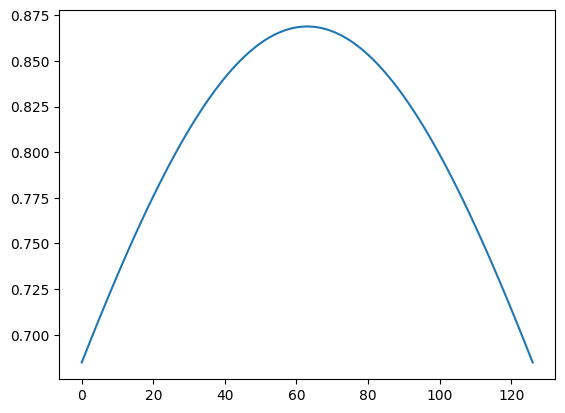

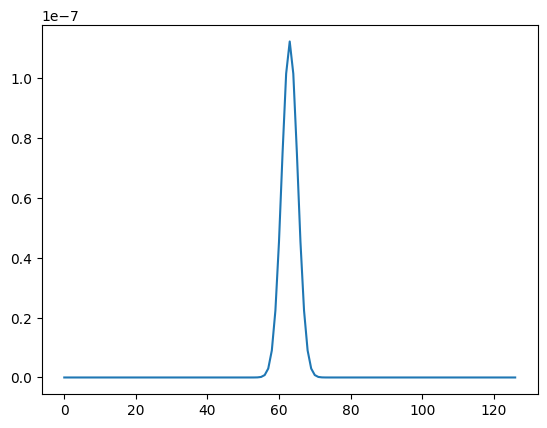

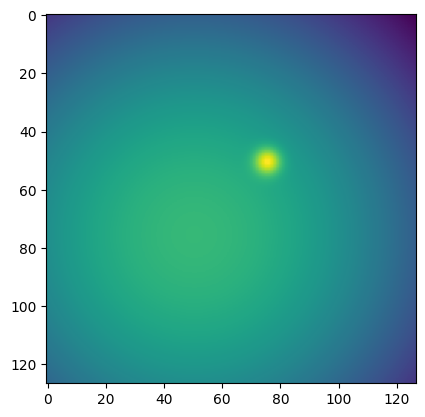

In [6]:
# data
Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
plt.plot(phi1(x, y,1))
plt.figure()
plt.plot(phi2(x, y, 20))
plt.figure()
plt.imshow(Phi[:,:,20])


In [7]:
print(Phi.shape)
np.save("../data/npy/toy1",scaled_Phi.T)

(127, 127, 500)


## MrCAE

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [8]:
# init model & load data
data_path = '../data/npy/toy1.npy'
model_path = '../model/toy1/'
result_path = '../result/toy1/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

In [9]:
# training
archs = [[1,2,3,4],[1,2,3,4],[1,3,5,7]]
tols = [0.001, 0.0005, 0.0001]
net.train_net(archs=archs, dataset=dataset, max_epoch=50, batch_size=350, 
              tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
              result_path=result_path, std=0.01, verbose=2)

*************************************************
Model @Level 0:
Perform deepening & widening, train each architectures ...
model layers: 
['activation', 'L0_Conv_0', 'L0_deConv_0']
losses printing format: local: mse/max/overall, global: mse/max/overall
epoch [1/50]
[training set] local: 0.0023/0.0293/0.0158, global: 0.0023/0.0293/0.0158
[validation set] local: 0.0024/0.0339/0.0182, global: 0.0024/0.0339/0.0182
epoch [5/50]:
[training set] local: 0.0004/0.0281/0.0143, global: 0.0004/0.0281/0.0142
[validation set] local: 0.0004/0.0303/0.0154, global: 0.0004/0.0303/0.0154
epoch [10/50]:
[training set] local: 0.0001/0.0286/0.0143, global: 0.0001/0.0286/0.0143
[validation set] local: 0.0001/0.0291/0.0146, global: 0.0001/0.0291/0.0146
epoch [15/50]:
[training set] local: 0.0001/0.0282/0.0142, global: 0.0001/0.0283/0.0142
[validation set] local: 0.0001/0.0291/0.0146, global: 0.0001/0.0291/0.0146
epoch [20/50]:
[training set] local: 0.0002/0.0277/0.0140, global: 0.0001/0.0277/0.0139
[validat

CAE(
  (activation): Sequential()
  (L0_Conv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_Conv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_Conv_2): Conv2dBlock(
    (activation): Sequential()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_2): Conv2dBlock(
    (activation): Sequential()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_Conv_3): Conv2dBlock(
    (activation): Sequential()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_3): Conv2dBlock(
    (activation): Sequential()
    (B0): ConvTranspose2d(1, 1, kerne

## Results

In [10]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L0_1
model_L0_2
model_L0_3
model_L1_0
model_L1_1
model_L1_2
model_L1_3
model_L2_0
model_L2_1
model_L2_2
model_L2_3


dict_keys(['0', '1', '2', '3'])
dict_keys(['0', '1', '2', '3'])
dict_keys(['0', '1', '2', '3'])


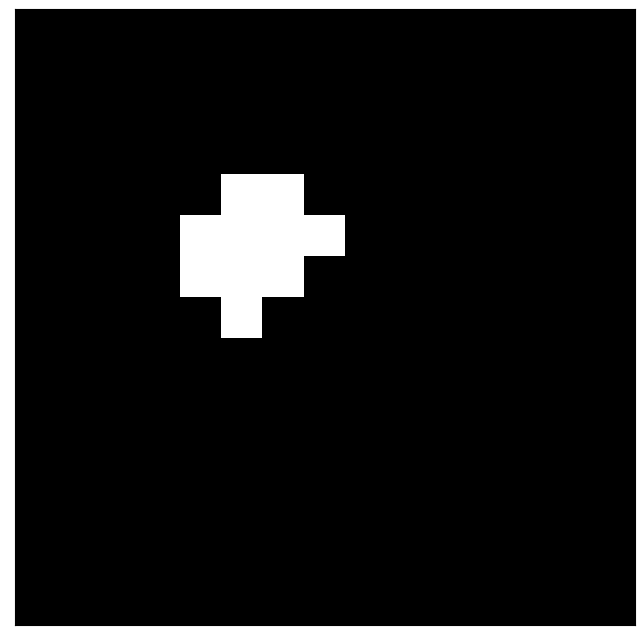

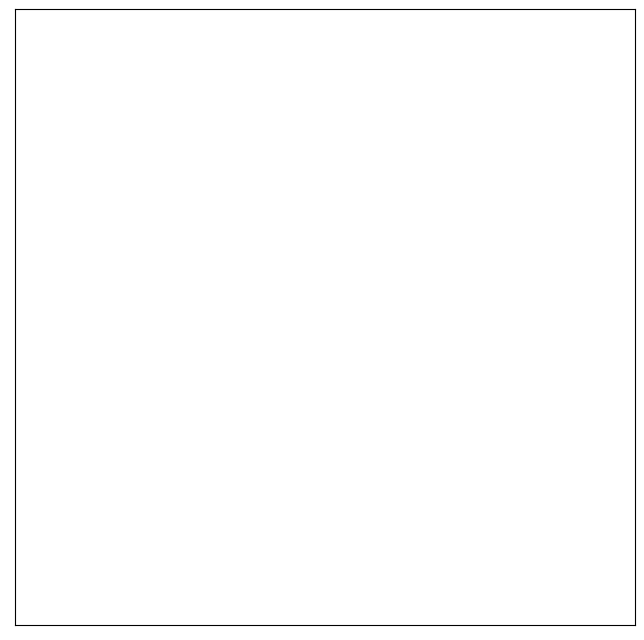

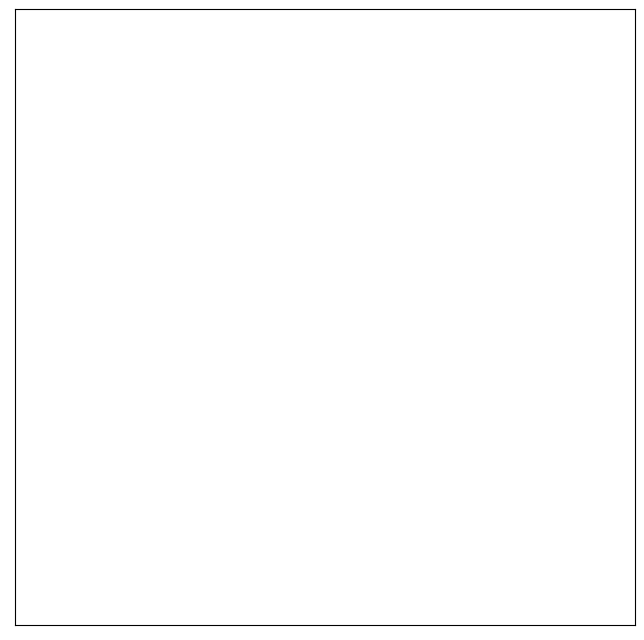

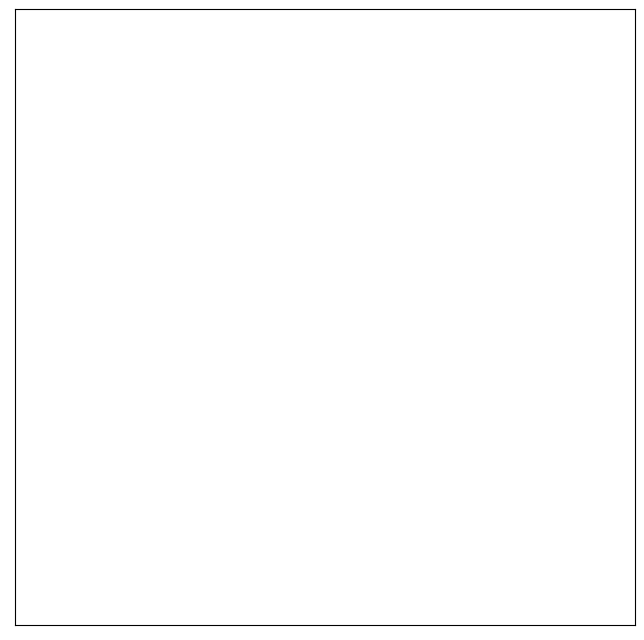

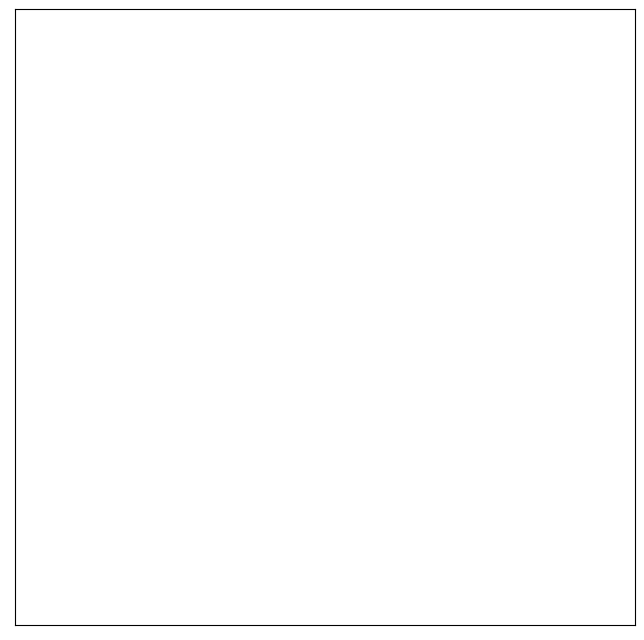

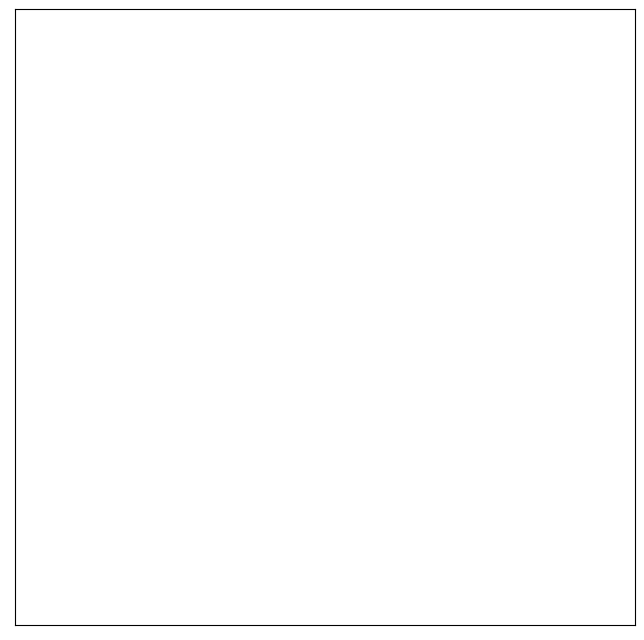

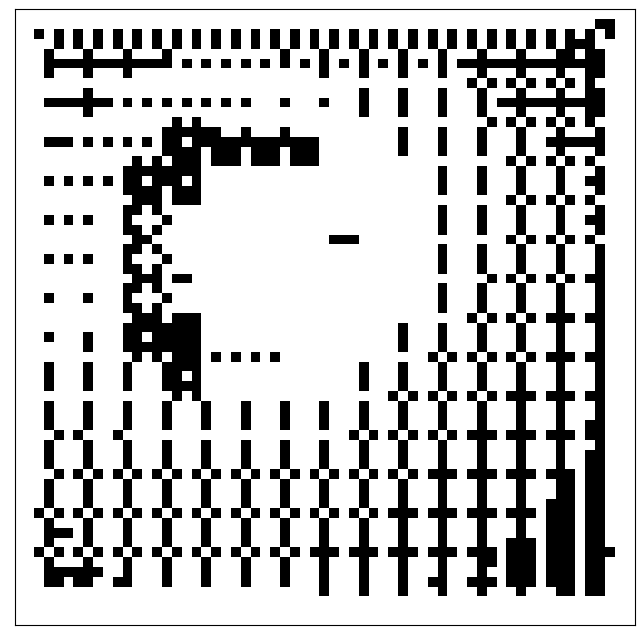

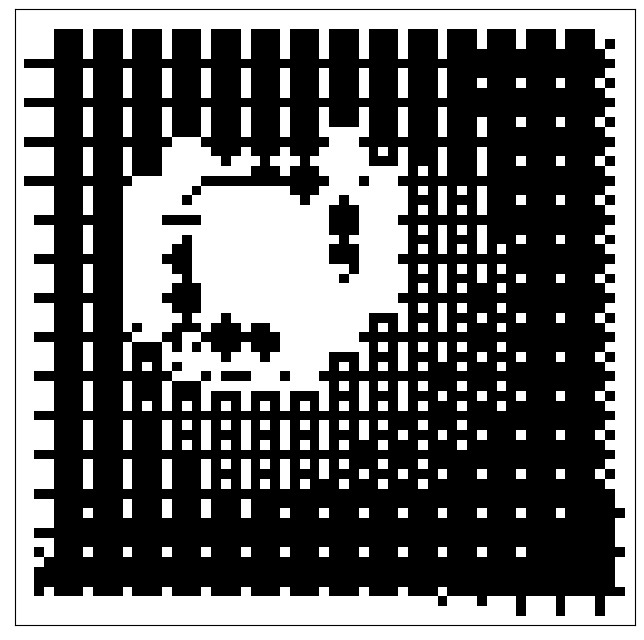

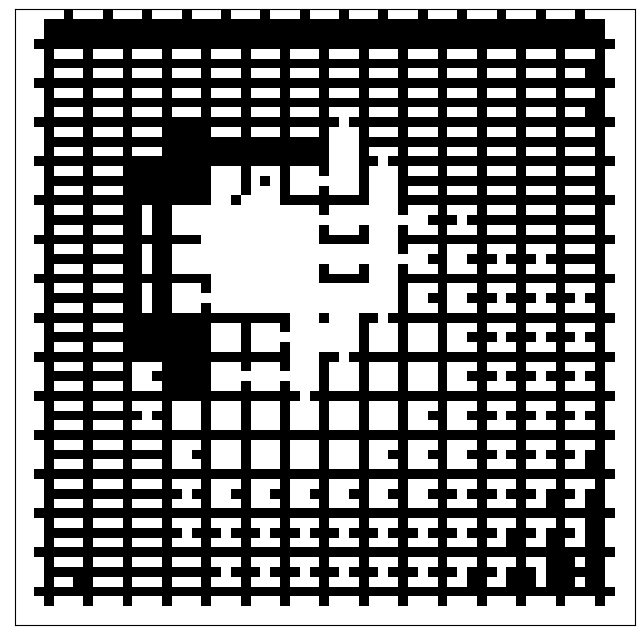

In [11]:
# choose the finest model
model = models['model_L2_3']

# resolved maps at different levels (that suggest poorly reconstructed regions)
for i in range(3):
    print(model.resolved_maps[str(i)].keys())

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I0.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I1.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['3'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I3.png'))

[ 19  26  33  39  46  50  54  60  68  74  77  83  89 120 124 126 129 163
 166 178 182 192 240 245 246 284 291 293 294 311 321 330 337 340 345 354
 360 362 366 376 406 414 416 420 424 428 441 442 477 480]
50
8
[19, 68, 129, 246, 337, 406]


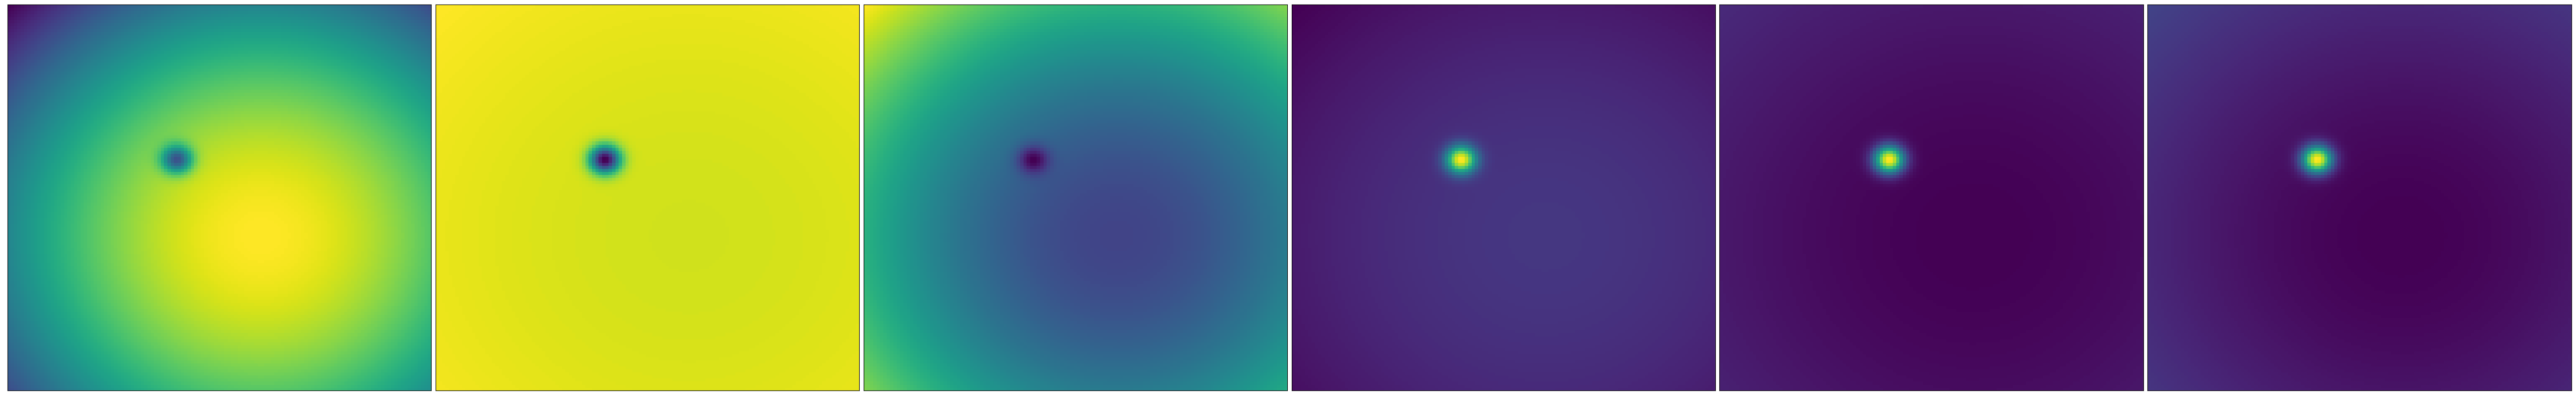

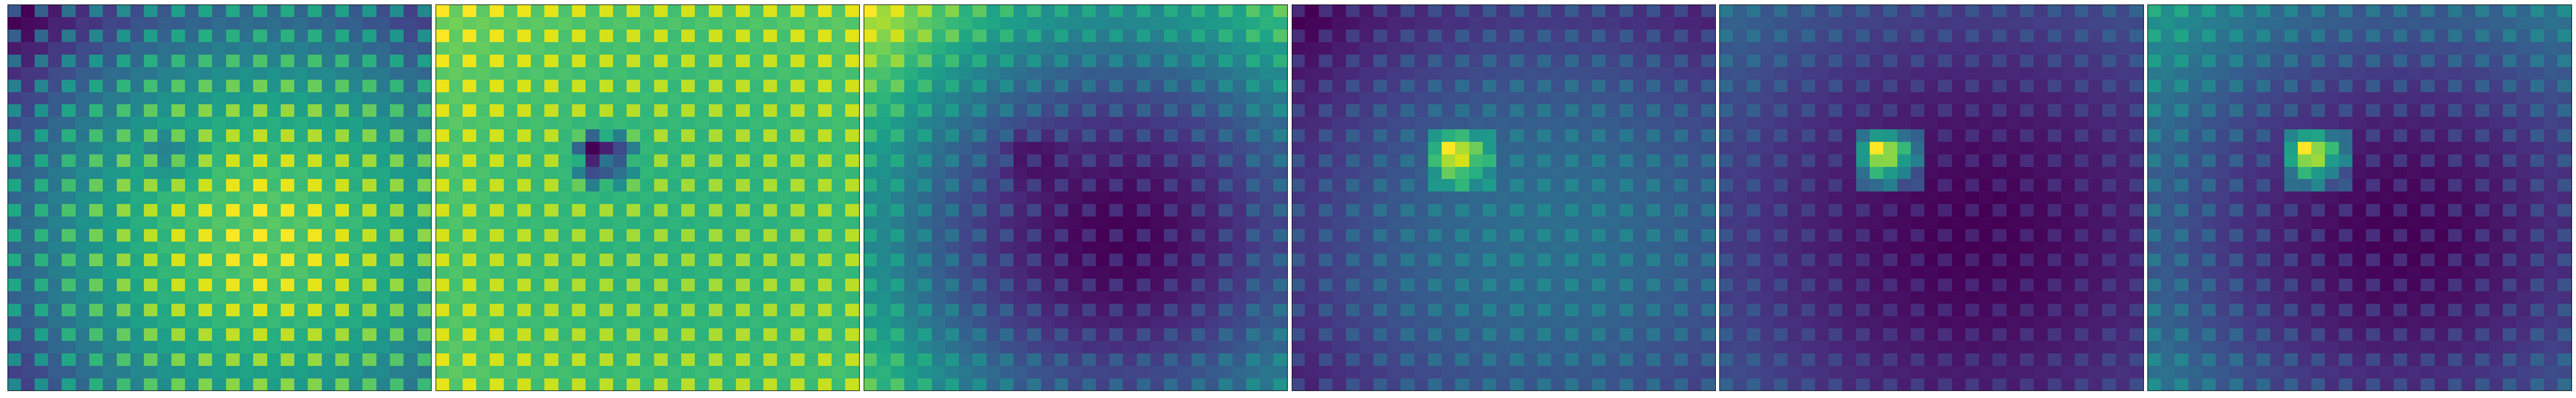

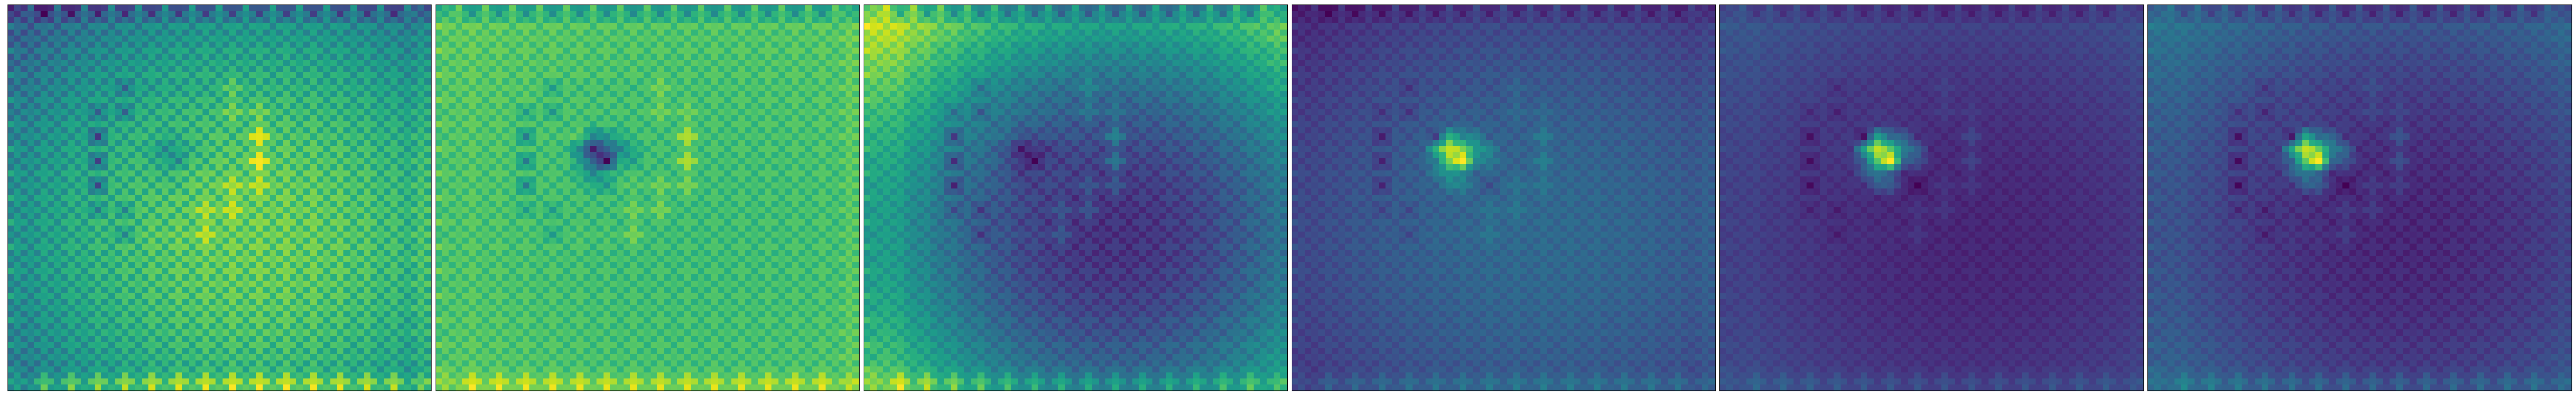

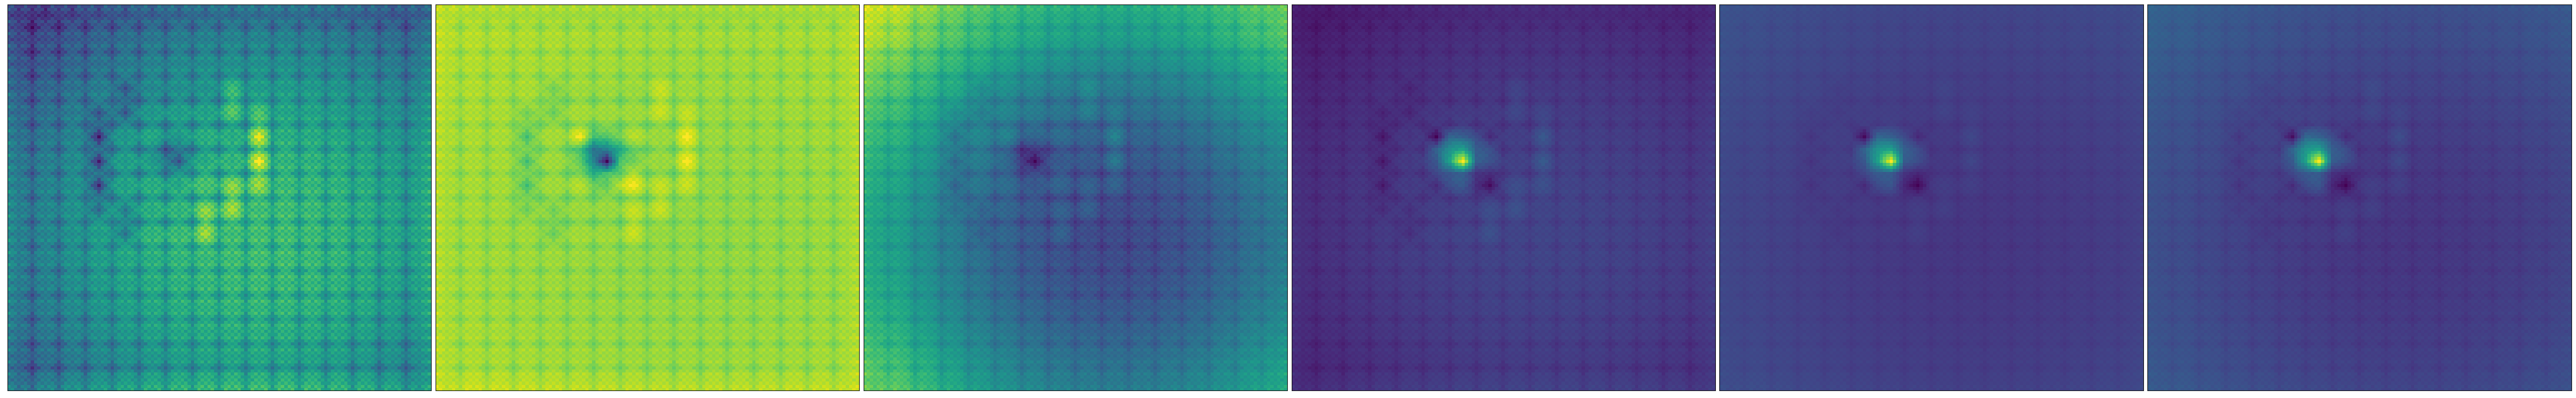

In [25]:
# reconstructions of test snapshots

inds = np.array(sorted(dataset.test_inds))
print(inds)
dataset.test_inds = inds
n_snapshots = len(inds)
print(n_snapshots)
n_samples = 6
n_step = n_snapshots // 6
print(n_step)
times=[]
for i in range(n_samples):
    times.append(inds[i*n_step])
print(times)


fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    axes[i].pcolor(dataset.data[inds[i*n_step], :, :, :].squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_samples.png'), bbox_inches='tight')


model = models['model_L0_1']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=0)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L0_reconstructions.png'), bbox_inches='tight')


model = models['model_L1_2']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=1)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L1_reconstructions.png'), bbox_inches='tight')


model = models['model_L2_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

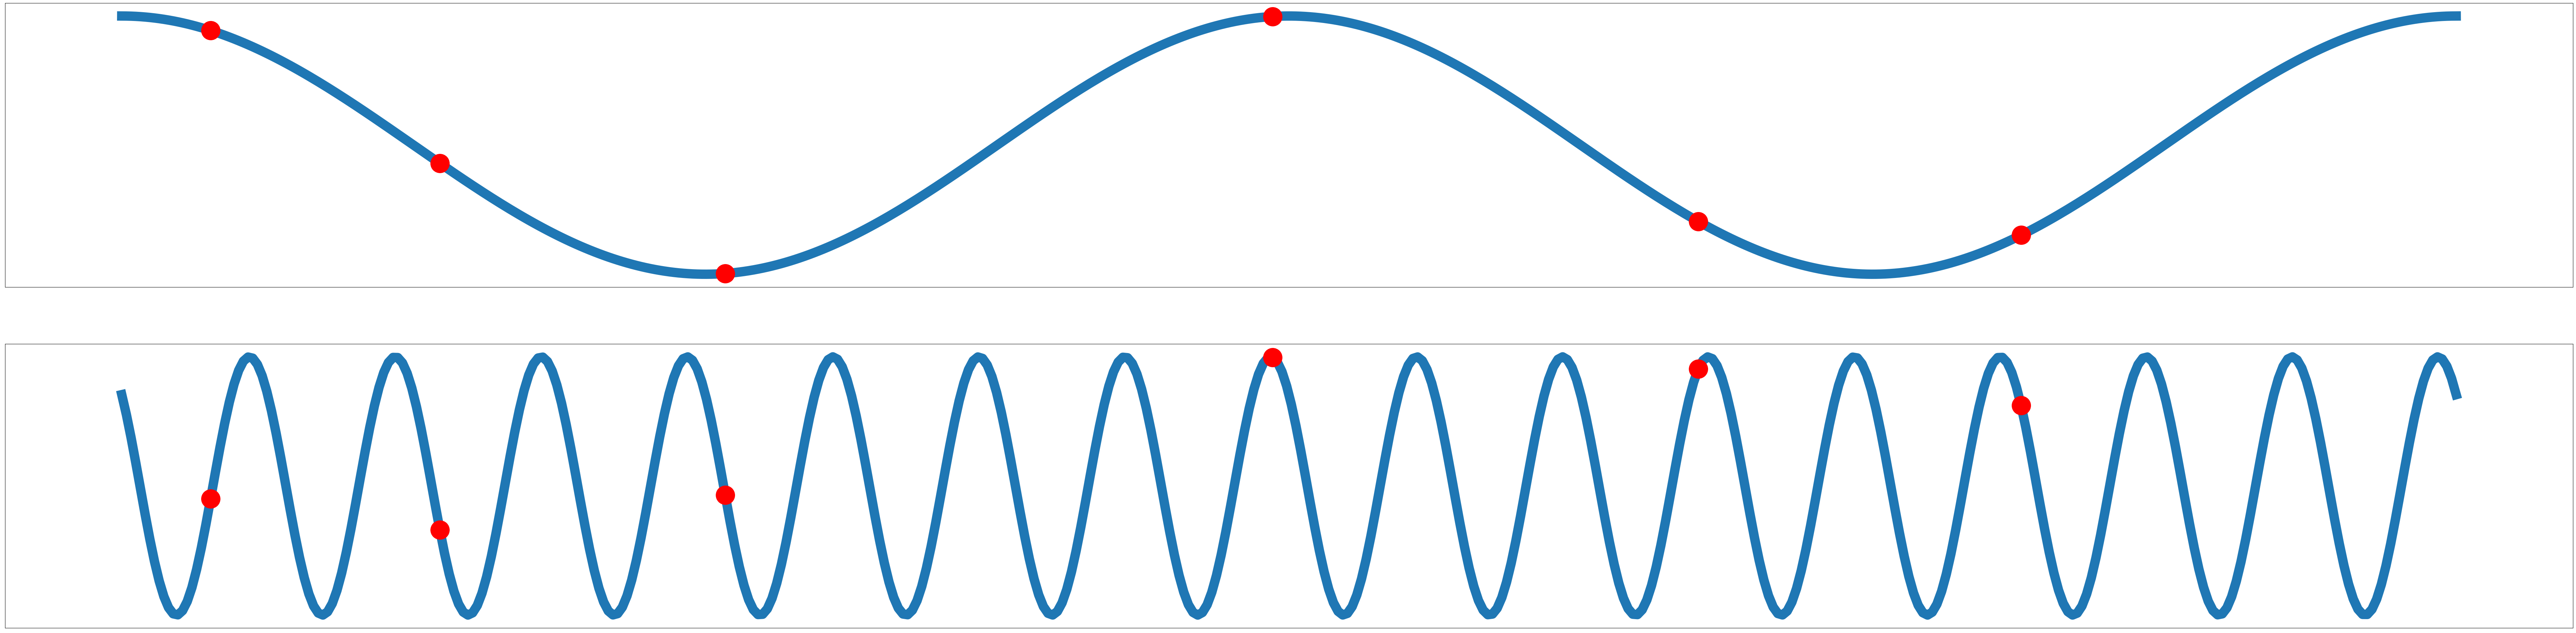

In [24]:
# fig1, axes = plt.subplots(2, 1, figsize=(8, 16))
# axes[0].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi1(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')
# axes[1].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi2(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')

# axes[0].set_xticks([])
# axes[1].set_xticks([])
# axes[0].set_yticks([])
# axes[1].set_yticks([])

# fig1.savefig(os.path.join(result_path, 'spatial_dynamics.png'))

fig2, axes = plt.subplots(2, 1, figsize=(14*7, 24))
axes[0].plot(t, np.cos(w0*t), t[times], np.cos(w0*t[times]), 'r.', linewidth=20, markersize=80)
axes[1].plot(t, np.cos(w1*t + np.pi/4), t[times], np.cos(w1*t[times] + np.pi/4), 'r.', linewidth=20, markersize=80)
#
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig2.savefig(os.path.join(result_path, 'temporal_dynamics.png'))

In [14]:
records = {}
for file_name in sorted(os.listdir(result_path)):
    if file_name.endswith('.dat'):
        key, _ = file_name.split('.')
        with open(os.path.join(result_path, file_name), 'rb') as f: 
            records[key]= pickle.load(f)

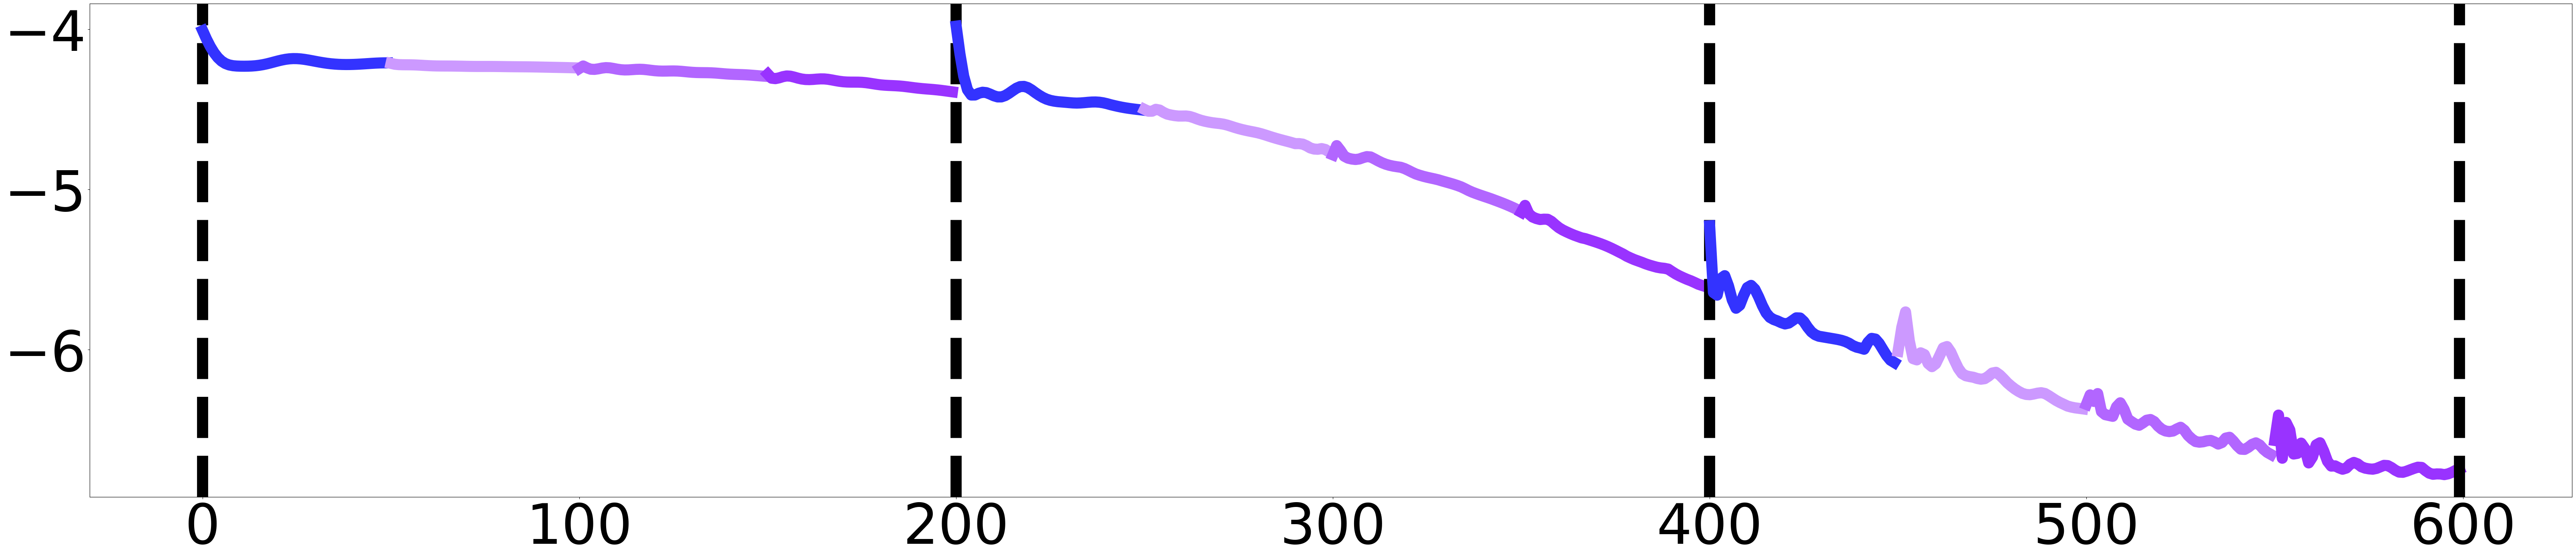

In [15]:
n_colors = 4
colors = [(51/255, 51/255, 255/255)]+ \
         [(204/255, 153/255, 255/255), 
          (178/255, 102/255, 255/255),
          (153/255, 51/255, 255/255),
          (127/255, 0/255, 255/255),
          (102/255, 0/255, 204/255),
          (76/255, 0/255, 153/255)]

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(80, 16))

# plot
s = 0
for i in range(3):
    level_errs = records['val_errs'][i]
    n_widens = len(level_errs)
    ax1.axvline(x=s, color='k', linestyle='--', linewidth=20)
    for j in range(n_widens):
        op_err = level_errs[j]
        ax1.plot(range(s, s + len(op_err)), np.log(op_err), color=colors[j], linewidth=20)
        s += len(op_err)
        
ax1.axvline(x=s-1, color='k', linestyle='--', linewidth=20)

ax1.xaxis.set_tick_params(labelsize=100)
ax1.yaxis.set_tick_params(labelsize=100)

fig1.savefig(os.path.join(result_path, 'err_iter_plot.png'))